# การทำความเข้าใจข้อมูลและการเตรียมข้อมูล (Data Understanding and Preprocessing)

In [304]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import  TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [305]:
#โหลดข้อมูลเครดิตจาก UCI
# https://archive.ics.uci.edu/dataset/28/japanese+credit+screening
data_path='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
data=pd.read_csv(data_path,names=['A'+str(i) for i in range(1,17)])

X = data.drop('A16', axis=1)
y = data['A16'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


num_cols=['A2','A3','A8','A14','A15']
category_cols=list(set(data.columns)-set(num_cols+['A16']))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [306]:
class CreditFeaturePreprocessing(TransformerMixin):
    def __init__(self,num_cols=[]):
        self.num_cols=num_cols

    def fit(self,X,y=None):
        return self

    def transform(self,X, y=None):
        # แทนที่ค่าที่หายไปด้วย np.nan
        X.replace('?',np.nan, inplace=True)
        # แปลงข้อมูลเป็น float
        X[self.num_cols]=X[self.num_cols].astype('float')
        return X

In [307]:
preprocessing=CreditFeaturePreprocessing(num_cols=num_cols) # เตรียมตัวแปลงชนิด
# ข้อมูลตัวเลข
imp_median=SimpleImputer(missing_values=np.nan,strategy='median') # เตรียมตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median)
z_score=StandardScaler() # เตรียมตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1
# ข้อมูล Categorical
imp_mode=SimpleImputer(missing_values=np.nan,strategy='most_frequent') # เตรียมตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode)
one_hot=OneHotEncoder(sparse_output=False,handle_unknown='ignore') # เตรียมตัวแปลงข้อมูลเป็น One-Hot Encoding


In [308]:
# the pipeline
num_preprocessing=Pipeline(steps=[
    ('missing impute',imp_median), # นำตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median) ใส่ใน pipeline
    ('scale',z_score)  # นำตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1 ใส่ใน pipeline
])

cat_preprocessing=Pipeline(steps=[
    ('missing impute',imp_mode), # นำตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode) ใส่ใน pipeline
    ('one hot',one_hot) # นำตัวแปลงข้อมูลแบบ One-Hot Encoding ใส่ใน pipeline
])

# สร้าง ColumnTransformer เพื่อจัดการกับการแปลงข้อมูลที่แตกต่างกัน
feature_transform = ColumnTransformer(
    [("num col", num_preprocessing, num_cols),  # ใช้ pipeline num_preprocessing สำหรับคอลัมน์ตัวเลข
     ("category col", cat_preprocessing, category_cols)])   # ใช้ pipeline cat_preprocessing สำหรับคอลัมน์ Categorical

# กำหนด parameter grid สำหรับ GridSearchCV
param_grid = {
    'penalty': [None, 'l2'],
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# สร้าง GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# สรา้ง pipeline โดยการรวมขั้นตอนทั้งหมดไว้ที่เดียว
model=Pipeline(steps=[
    ('preprocessing',preprocessing),
    ('feature transform',feature_transform),
    ('classification',grid_search)
])

In [309]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x00000205D18E5C90>),
                ('feature transform',
                 ColumnTransformer(transformers=[('num col',
                                                  Pipeline(steps=[('missing '
                                                                   'impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['A2', 'A3', 'A8', 'A14',
                                                   'A15']),
                                                 ('category col',
                                                  Pipeline(steps=[('missing '
                                                                   'impute',
                                                                   SimpleImpute...ost_frequent')),
                                                                  ('one hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A6', 'A4', 'A11',
                                                   'A9', 'A7', 'A5', 'A13',
                                                   'A12', 'A10'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

In [310]:
y_pred=model.predict(X_test)

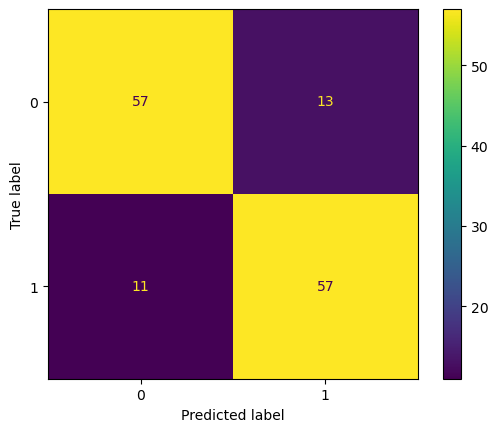

In [311]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [312]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.81      0.83        70
           1       0.81      0.84      0.83        68

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



In [313]:
model.steps[-1][-1].best_params_

{'C': 0.001, 'penalty': None, 'solver': 'sag'}

In [314]:
model.steps[2][1].best_params_

{'C': 0.001, 'penalty': None, 'solver': 'sag'}

In [315]:
# สร้าง pipeline เพื่อนำไปใช้งาน
model=Pipeline(steps=[
    ('preprocessing',preprocessing),
    ('feature transform',feature_transform),
    ('classification',LogisticRegression(C=0.001,penalty=None,solver='sag'))
])

In [316]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x00000205D18E5C90>),
                ('feature transform',
                 ColumnTransformer(transformers=[('num col',
                                                  Pipeline(steps=[('missing '
                                                                   'impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['A2', 'A3', 'A8', 'A14',
                                                   'A15']),
                                                 ('category col',
                                                  Pipeline(steps=[('missing '
                                                                   'impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A6', 'A4', 'A11',
                                                   'A9', 'A7', 'A5', 'A13',
                                                   'A12', 'A10'])])),
                ('classification',
                 LogisticRegression(C=0.001, penalty=None, solver='sag'))])

In [317]:
model.steps[-1][-1]

LogisticRegression(C=0.001, penalty=None, solver='sag')

In [318]:
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83        70
           1       0.81      0.84      0.83        68

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



# การเลือกค่า threshold ของผลการทำนายเพื่อให้เหมาะสมกับการใช้งานมากที่สุด

ในกรณีที่ต้องการให้ความสำคัญกับบาง class เป็นพิเศษเพียง class เดียว สามารถกำหนดค่า threshold เพื่อการทำนายฉพาะ class นั้นได้

โดยปกติเมื่อฝึกแบบจำลองเสร็จแล้วแล้วต้องการให้แบบจำลองทำได้เพื่อจำแนกประเภทข้อมูล หากการทำนายเป็น 2 ประเภท แบบจำลองจะทำนายค่าอยู่ในช่วง 0-1 แล้วจะใช้ค่า threshold เป็น 0.5 เพื่อตัดสินว่าเป็น Class 0 หรือ Class 1

อย่างไรก็ตามในงานบางประเภทอาจให้ความสำคัญกับการประเมินประสิทธิภาพของแบบจำลองแตกต่างกันตัวอย่างเช่นงานที่ต้องการความแม่นยำสูงอาจต้องการการทำนายที่ถูกต้องที่สุดเท่านั้นจึงไม่ยอมให้มีการผิดพลาดเกิดขึ้นเพราะอาจเกิดการเสียหายได้ ในขณะที่งานคัดกรองอาจต้องการคัดกรองให้ครอบคลุมผู้ป่วยมากที่สุดเพื่อมาตรวจละเอียดอีกครั้งหนึ่งจึงยอมให้มีความผิดพลาดได้ในระดับหนึ่งเป็นต้น

ในกรณีที่เราฝึกแบบจำลองและได้แบบจำลองที่ดีที่สุดมาแล้วเราสามารถที่จะเลือกค่า threshold ที่เหมาะสมเพิ่มเติมซึ่งสามารถพิจารณาได้โดยการทดลองปรับค่า threshold แล้ววัดประสิทธิภาพไม่ว่าจะเป็น Precision กับ Recall หรือ Sensitivity กับ  Specificity

## ทดลองเลือก threshold เพื่อให้เหมาะสมกับงานที่จะนำไปใช้มากที่สุด

* เลือกจาก Sensitivity และ Specificity ดู ROC cerve
* เลือกจาก Precision และ Recall ดู  Precision-Recall curve

# วิเคราะห์ ROC ตาม class ที่สนใจ

In [319]:
# ตรวจสอบ class ที่ต้องการพิจารณา
print(label_encoder.classes_)
label_encoder.inverse_transform([0,0,1,1])

['+' '-']


array(['+', '+', '-', '-'], dtype=object)

In [320]:
# เลือก Class ที่สนใจ และทำให้ Class มี y เป็น 1 นอกนั้นให้เป็น 0
y_test_target=(y_test==0).astype(int)

In [321]:
y_test_target

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1])

In [322]:
#  class + -> 0
import plotly.express as px
from sklearn.metrics import roc_curve, auc
# หา fpr, tpr
y_prob=model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test_target, y_prob[:,0])

In [323]:
y_prob

array([[6.57249369e-03, 9.93427506e-01],
       [5.89077095e-01, 4.10922905e-01],
       [2.94052528e-02, 9.70594747e-01],
       [5.80981589e-02, 9.41901841e-01],
       [2.51994662e-03, 9.97480053e-01],
       [3.84694414e-01, 6.15305586e-01],
       [6.55473488e-02, 9.34452651e-01],
       [4.37280188e-01, 5.62719812e-01],
       [2.59595425e-02, 9.74040457e-01],
       [2.18606758e-02, 9.78139324e-01],
       [5.25749225e-02, 9.47425077e-01],
       [8.62340185e-01, 1.37659815e-01],
       [1.25004524e-02, 9.87499548e-01],
       [6.48861160e-01, 3.51138840e-01],
       [2.45436432e-01, 7.54563568e-01],
       [5.98362946e-01, 4.01637054e-01],
       [3.04984478e-02, 9.69501552e-01],
       [1.54087664e-02, 9.84591234e-01],
       [2.06648967e-01, 7.93351033e-01],
       [1.54141898e-01, 8.45858102e-01],
       [2.17135321e-02, 9.78286468e-01],
       [6.38196870e-02, 9.36180313e-01],
       [5.19027158e-03, 9.94809728e-01],
       [8.65119724e-01, 1.34880276e-01],
       [8.086488

In [324]:
list(zip(fpr,tpr))[:5]

[(0.0, 0.0),
 (0.0, 0.014285714285714285),
 (0.0, 0.37142857142857144),
 (0.029411764705882353, 0.37142857142857144),
 (0.029411764705882353, 0.4)]

In [325]:
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500,
    hover_data={'Thresholds': thresholds}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=0, x1=1, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


              precision    recall  f1-score   support

           0       0.87      0.81      0.84        68
           1       0.83      0.89      0.86        70

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138



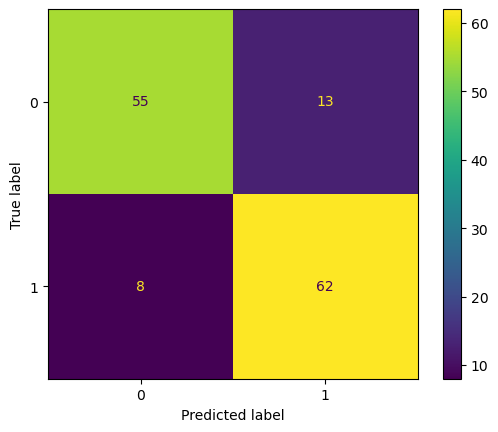

In [326]:
selected_threshold=0.38
y_pred=y_prob[:,0]>=selected_threshold
print(classification_report(y_test_target,y_pred))
cm=confusion_matrix(y_test_target,y_pred,labels=[0,1])
ConfusionMatrixDisplay(cm).plot()

In [327]:
from sklearn.metrics import precision_recall_curve

In [328]:
# หา precision, recall
precision, recall, thresholds = precision_recall_curve(y_test_target, y_prob[:,0])

In [329]:
thresholds=np.append(thresholds,1)
metrics = pd.DataFrame({'precision': precision, 'recall': recall,'thresholds':thresholds})
fig = px.area(metrics,
    x='precision', y='recall',
    title=f'Precision Recall Curve',
    labels=dict(y='Recall', x='Precision'),
    width=700, height=500,
    hover_data='thresholds'
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=1, x1=1, y1=0
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

## สร้าง function เพื่อปรับ Output ให้เสมือนตัดสินใจที่ 0.5

In [330]:
def finetuneProb(score,threshold=0.4):
  if score<threshold:
    score=score/threshold*0.5
  else:
    score=(score-threshold)/(1-threshold)*(1-0.5)+0.5
  return score

In [331]:
def finetuneProb_array(score,threshold=0.4):
  ind=score<threshold
  score[ind]=score[ind]/threshold*0.5
  score[not(ind)]=(score[not(ind)]-threshold)/(1-threshold)*(1-0.5)+0.5
  return score

In [332]:
import numpy as np
import plotly.express as px
prob_old=[0,0.38,1]
prob_new=[0,0.5,1]
xnew = np.linspace(0,1,num=101)
ynew = np.interp(xnew,prob_old,prob_new)
fig = px.line(x=xnew,y=ynew,title='linspace interpolation')
fig.show()

In [333]:
from scipy.interpolate import CubicSpline
prob_old=[0,0.38,1]
prob_new=[0,0.5,1]
xnew = np.linspace(0,1,num=101)
cs = CubicSpline(prob_old,prob_new)
ynew = cs(xnew)
fig = px.line(x=xnew,y=ynew,title='linspace interpolation')
fig.show()


In [334]:
def prob_mapping_generator(threshold,interpolate='CubicSpline'):
   prob_old=[0,threshold,1]
   prob_new=[0,0.5,1]
   if interpolate=='linspace':
      return lambda x: np.interp(x, prob_old, prob_new)
   return CubicSpline(prob_old, prob_new)


In [335]:
prob_mapping=prob_mapping_generator(0.38,interpolate='linspace')
xnew = np.linspace(0, 1, num=101)
ynew = prob_mapping(xnew)
fig = px.line(x=xnew, y=ynew, title='Linspace Interpolation')
fig.show()

In [336]:
prob_mapping=prob_mapping_generator(0.38,interpolate='CubicSpline')
xnew = np.linspace(0, 1, num=101)
ynew = prob_mapping(xnew)
fig = px.line(x=xnew, y=ynew, title='Cubic Spline Interpolation')
fig.show()

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        68
           1       0.83      0.89      0.86        70

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138



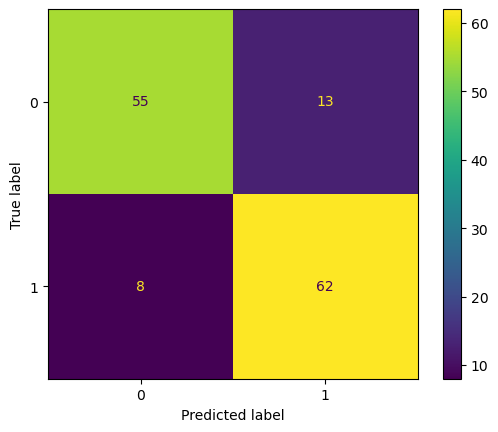

In [337]:
prob_mapping=prob_mapping_generator(0.38,interpolate='CubicSpline')

y_pred=prob_mapping(y_prob[:,0])>0.5
print(classification_report(y_test_target,y_pred))
cm=confusion_matrix(y_test_target,y_pred,labels=[0,1])
ConfusionMatrixDisplay(cm).plot()

# Simple GUI deployment example

In [338]:
import ipywidgets as widgets
from IPython.display import display

In [339]:
# prompt: write a GUI to allow user input all required by the model

import pandas as pd
# Create input widgets
style = {'description_width': 'initial'}
A1 = widgets.Dropdown(options=X['A1'].unique(), description='A1:', style=style)
A2 = widgets.FloatText(description='A2:', style=style)
A3 = widgets.FloatText(description='A3:', style=style)
A4 = widgets.Dropdown(options=X['A4'].unique(), description='A4:', style=style)
A5 = widgets.Dropdown(options=X['A5'].unique(), description='A5:', style=style)
A6 = widgets.Dropdown(options=X['A6'].unique(), description='A6:', style=style)
A7 = widgets.Dropdown(options=X['A7'].unique(), description='A7:', style=style)
A8 = widgets.FloatText(description='A8:', style=style)
A9 = widgets.Dropdown(options=X['A9'].unique(), description='A9:', style=style)
A10 = widgets.Dropdown(options=X['A10'].unique(), description='A10:', style=style)
A11 = widgets.IntText(description='A11:', style=style)
A12 = widgets.Dropdown(options=X['A12'].unique(), description='A12:', style=style)
A13 = widgets.Dropdown(options=X['A13'].unique(), description='A13:', style=style)
A14 = widgets.FloatText(description='A14:', style=style)
A15 = widgets.IntText(description='A15:', style=style)

# Create a button to trigger prediction
predict_button = widgets.Button(description="Predict")

# Display widgets
input_widgets = widgets.VBox([A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, A15, predict_button])
display(input_widgets)

prob_mapping=prob_mapping_generator(0.38,interpolate='CubicSpline')

# Define prediction function
def predict(button):
  input_data = pd.DataFrame([[A1.value, A2.value, A3.value, A4.value, A5.value, A6.value, A7.value,
                              A8.value, A9.value, A10.value, A11.value, A12.value, A13.value, A14.value, A15.value]],
                            columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'])

  predict_prob = model.predict_proba(input_data)
  predict_prob = prob_mapping(predict_prob[:,0])
  prediction = predict_prob>0.5

  print(input_data)
  if prediction[0] == 1:
    print(f"Prediction: + (positive: {predict_prob})")
  else:
    print(f"Prediction: - (negative: {1-predict_prob})")

# Attach prediction function to button click
predict_button.on_click(predict)


# Workshop 04 Hands On

สร้าง prediction model โดยใช้ข้อมูลที่กำหนดให้นี้ พร้อมเลือก prediction probability threshold ที่เหมาะสม

https://github.com/praisan/hello-world/raw/master/german_credit_data.csv

In [340]:
df_4 = pd.read_csv('https://github.com/praisan/hello-world/raw/master/german_credit_data.csv')

In [341]:
class CreditFeaturePreprocessing(TransformerMixin):
    def __init__(self,str_cols=[]):
        self.str_cols=str_cols

    def fit(self,X,y=None):
        return self

    def transform(self,X, y=None):

        # แปลงข้อมูลเป็น float
        X[self.str_cols] = X[self.str_cols].astype(str)
        return X

In [342]:
num_cols=['Age','Credit amount','Duration']
category_cols=list(set(df_4.columns)-set(num_cols+['Risk']))

In [343]:
preprocessing = CreditFeaturePreprocessing(category_cols)

In [344]:
z_score = StandardScaler()

num_preprocessing=Pipeline(steps=[
    ('StandardScaler', z_score)
])

In [345]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_preprocessing=Pipeline(steps=[
    ('missingvalue_mode_imputer', imp_mode),
    ('onehotEncoder', onehot)
])

In [346]:
feature_transform = ColumnTransformer([
    ('number_preprocessing', num_preprocessing, num_cols),
    ('category_preprocessing', cat_preprocessing, category_cols)
    ])

In [347]:
param_grid = {
    'penalty': [None, 'l2'],
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

In [348]:
model_3=Pipeline(steps=[
    ('str_preprocessing',preprocessing),
    ('feature proprocessing', feature_transform),
    ('GradientBoostingClassifier_gridsearch', grid_search)
])

In [349]:
X = df_4.drop(['Risk'], axis=1)
y = df_4['Risk'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [351]:
model_3.fit(X_train,y_train)

Pipeline(steps=[('str_preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x00000205D2DFD550>),
                ('feature proprocessing',
                 ColumnTransformer(transformers=[('number_preprocessing',
                                                  Pipeline(steps=[('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('category_preprocessing',
                                                  Pipeline(steps=[('missingvalue_mode_imputer',
                                                                   SimpleIm...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Purpose',
                                                   'Saving accounts', 'Job',
                                                   'Unnamed: 0',
                                                   'Checking account',
                                                   'Housing'])])),
                ('GradientBoostingClassifier_gridsearch',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

In [352]:
print(classification_report(y_test, model_3.predict(X_test)))

              precision    recall  f1-score   support

           0       0.63      0.37      0.47        59
           1       0.78      0.91      0.84       141

    accuracy                           0.75       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.73      0.75      0.73       200



In [353]:
model_3.steps[2][1].best_params_

{'C': 0.001, 'penalty': None, 'solver': 'newton-cg'}

In [354]:
model_3=Pipeline(steps=[
    ('str_preprocessing',preprocessing),
    ('feature proprocessing', feature_transform),
    ('GradientBoostingClassifier_gridsearch', LogisticRegression(C=0.001, penalty=None, solver='newton-cg'))
])

In [355]:
model_3.fit(X_train,y_train)

Pipeline(steps=[('str_preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x00000205D2DFD550>),
                ('feature proprocessing',
                 ColumnTransformer(transformers=[('number_preprocessing',
                                                  Pipeline(steps=[('StandardScaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Credit amount',
                                                   'Duration']),
                                                 ('category_preprocessing',
                                                  Pipeline(steps=[('missingvalue_mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Purpose',
                                                   'Saving accounts', 'Job',
                                                   'Unnamed: 0',
                                                   'Checking account',
                                                   'Housing'])])),
                ('GradientBoostingClassifier_gridsearch',
                 LogisticRegression(C=0.001, penalty=None,
                                    solver='newton-cg'))])

In [356]:
y_pred = model_3.predict(X_test)

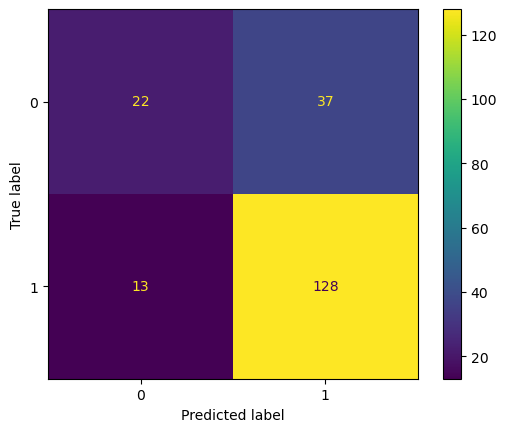

In [357]:
cm = confusion_matrix(y_test, y_pred, labels=model_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_3.classes_)
disp.plot()

In [358]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.37      0.47        59
           1       0.78      0.91      0.84       141

    accuracy                           0.75       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.73      0.75      0.73       200



In [359]:
label_encoder.classes_

array(['bad', 'good'], dtype=object)

In [360]:
label_encoder.inverse_transform([0,1])

array(['bad', 'good'], dtype=object)

In [361]:
y_prob=model_3.predict_proba(X_test)

In [362]:
#class 0

y_test_target_0=(y_test==0).astype(int) 
fpr, tpr, thresholds = roc_curve(y_test_target_0, y_prob[:,0])
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500,
    hover_data={'Thresholds': thresholds}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=0, x1=1, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


In [363]:
# selected_threshold=0.0001
# y_pred=y_prob[:,0]>=selected_threshold
# print(classification_report(y_test_target,y_pred))
# cm=confusion_matrix(y_test_target,y_pred,labels=[1,0])
# ConfusionMatrixDisplay(cm).plot()

In [364]:
precision, recall, thresholds = precision_recall_curve(y_test_target_0, y_prob[:,0])

In [365]:
thresholds=np.append(thresholds,1)
metrics = pd.DataFrame({'precision': precision, 'recall': recall,'thresholds':thresholds})
fig = px.area(metrics,
    x='precision', y='recall',
    title=f'Precision Recall Curve',
    labels=dict(y='Recall', x='Precision'),
    width=700, height=500,
    hover_data='thresholds'
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=1, x1=1, y1=0
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [366]:
y_test_target_1=(y_test==1).astype(int) 
fpr, tpr, thresholds = roc_curve(y_test_target_1, y_prob[:,1])
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500,
    hover_data={'Thresholds': thresholds}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=0, x1=1, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [367]:
precision, recall, thresholds = precision_recall_curve(y_test_target_1, y_prob[:,1])

In [368]:
thresholds=np.append(thresholds,1)
metrics = pd.DataFrame({'precision': precision, 'recall': recall,'thresholds':thresholds})
fig = px.area(metrics,
    x='precision', y='recall',
    title=f'Precision Recall Curve',
    labels=dict(y='Recall', x='Precision'),
    width=700, height=500,
    hover_data='thresholds'
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=1, x1=1, y1=0
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [369]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

prob_mapping=prob_mapping_generator(0.5,interpolate='linspace')
y_prob_0 = prob_mapping(y_prob[:, 0])
print(y_test_target_0[:5])
print((y_pred[:5] == 0).astype(int))
print(y_prob[:5, 0])
print(y_prob_0[:5])
y_prob_1 = prob_mapping(y_prob[:, 1])

# Calculate ROC curve and AUC for each class
y_test_target_0 = (y_test == 0).astype(int)
fpr0, tpr0, thresholds0 = roc_curve(y_test_target_0, y_prob_0)
roc_auc0 = auc(fpr0, tpr0)

y_test_target_1 = (y_test == 1).astype(int)
fpr1, tpr1, thresholds1 = roc_curve(y_test_target_1, y_prob_1)
roc_auc1 = auc(fpr1, tpr1)

# Create a combined figure
fig = go.Figure()

# Add the first ROC curve
fig.add_trace(go.Scatter(
    x=fpr0, y=tpr0,
    mode='lines',
    name=f'Class 0 ROC Curve (AUC={roc_auc0:.4f})',
    line=dict(color='blue'),
    hovertemplate='False Positive Rate: %{x}<br>True Positive Rate: %{y}<br>Threshold: %{customdata:.4f}',
    customdata=thresholds0
))

# Add the second ROC curve
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1,
    mode='lines',
    name=f'Class 1 ROC Curve (AUC={roc_auc1:.4f})',
    line=dict(color='red'),
    hovertemplate='False Positive Rate: %{x}<br>True Positive Rate: %{y}<br>Threshold: %{customdata:.4f}',
    customdata=thresholds1
))

# Add a diagonal line for reference
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=0, x1=1, y1=1
)

# Update axes and layout
fig.update_layout(
    title='ROC Curves for Class 0 and Class 1',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700, height=500
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

# Show the plot
fig.show()

[1 0 0 0 0]
[0 0 1 0 0]
[0.48639154 0.33172942 0.54254356 0.01622433 0.0194262 ]
[0.48639154 0.33172942 0.54254356 0.01622433 0.0194262 ]


In [370]:
print(classification_report(y_test,y_pred, output_dict=True))

{'0': {'precision': 0.6285714285714286, 'recall': 0.3728813559322034, 'f1-score': 0.46808510638297873, 'support': 59.0}, '1': {'precision': 0.7757575757575758, 'recall': 0.9078014184397163, 'f1-score': 0.8366013071895425, 'support': 141.0}, 'accuracy': 0.75, 'macro avg': {'precision': 0.7021645021645022, 'recall': 0.6403413871859598, 'f1-score': 0.6523432067862607, 'support': 200.0}, 'weighted avg': {'precision': 0.7323376623376623, 'recall': 0.75, 'f1-score': 0.7278890279516063, 'support': 200.0}}


In [371]:
precision_0 = []
recall_0 = []
precision_1 = []
recall_1 = []
accuracy = []

for threshold in np.arange(0,1,0.0001):
    y_pred_threshold_0=y_prob[:,0]>=threshold
    score = classification_report(y_test_target_0,y_pred_threshold_0, output_dict=True)
    accuracy.append(score['accuracy'])
    precision_0.append(score['0']['precision'])
    recall_0.append(score['0']['recall'])
    precision_1.append(score['1']['precision'])
    recall_1.append(score['1']['recall'])
    

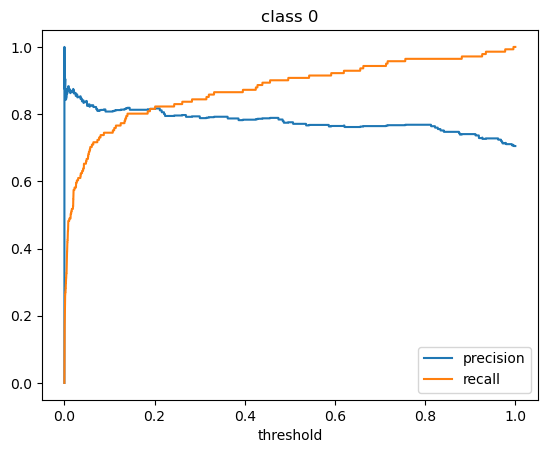

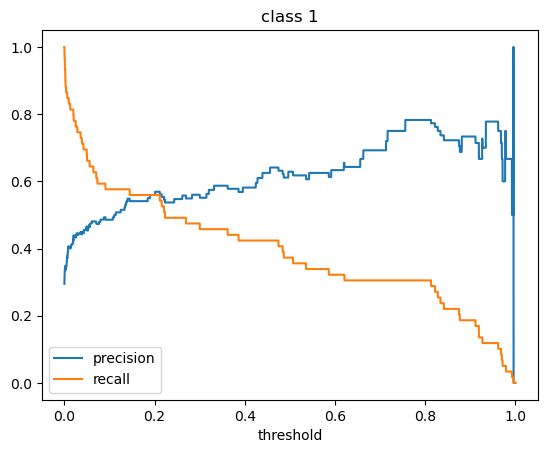

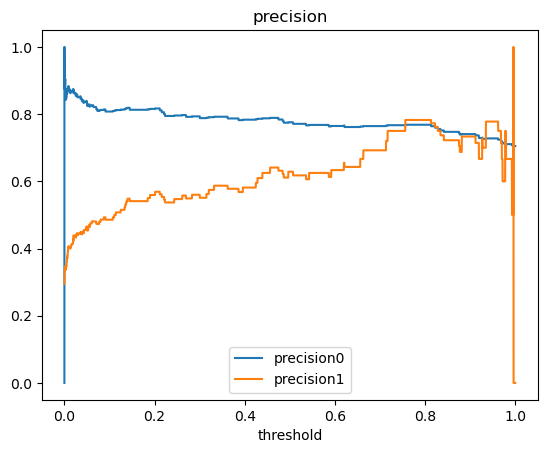

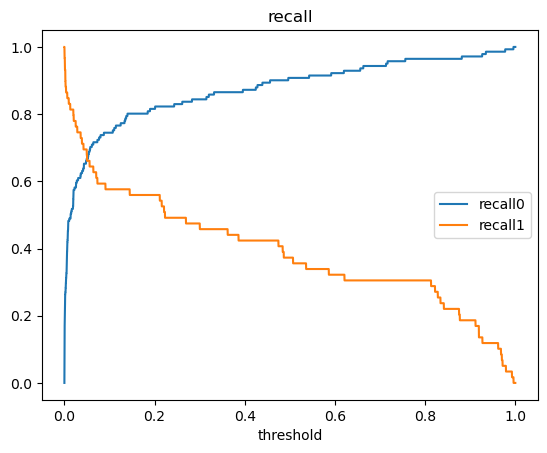

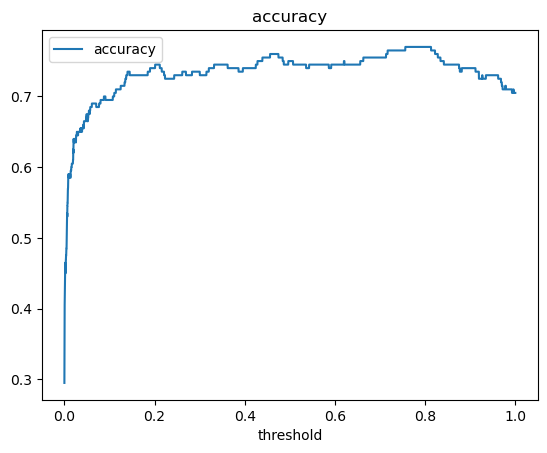

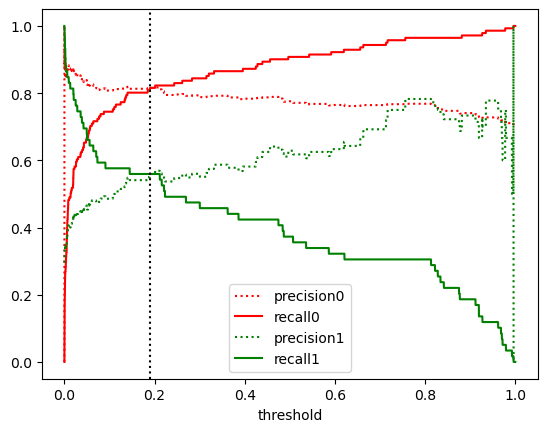

In [372]:
import matplotlib.pyplot as plt
plt.title('class 0')
plt.plot(np.arange(0,1,0.0001), precision_0, label ='precision')
plt.plot(np.arange(0,1,0.0001), recall_0, label ='recall')
plt.xlabel('threshold')
plt.legend()
plt.show()

plt.title('class 1')
plt.plot(np.arange(0,1,0.0001), precision_1, label ='precision')
plt.plot(np.arange(0,1,0.0001), recall_1, label ='recall')
plt.xlabel('threshold')
plt.legend()
plt.show()

plt.title('precision')
plt.plot(np.arange(0,1,0.0001), precision_0, label ='precision0')
plt.plot(np.arange(0,1,0.0001), precision_1, label ='precision1')
plt.xlabel('threshold')
plt.legend()
plt.show()

plt.title('recall')
plt.plot(np.arange(0,1,0.0001), recall_0, label ='recall0')
plt.plot(np.arange(0,1,0.0001), recall_1, label ='recall1')
plt.xlabel('threshold')
plt.legend()
plt.show()

plt.title('accuracy')
plt.plot(np.arange(0,1,0.0001), accuracy, label ='accuracy')
plt.xlabel('threshold')
plt.legend()
plt.show()

plt.plot(np.arange(0,1,0.0001), precision_0, 'r:', label ='precision0')
plt.plot(np.arange(0,1,0.0001), recall_0, 'r', label ='recall0')
plt.plot(np.arange(0,1,0.0001), precision_1, 'g:', label ='precision1')
plt.plot(np.arange(0,1,0.0001), recall_1, 'g', label ='recall1')
plt.axvline(x = 0.19, color = 'k', linestyle = ':')
plt.xlabel('threshold')
plt.legend()
plt.show()

In [373]:
new_threshold = 0.19

prob_mapping=prob_mapping_generator(new_threshold,interpolate='linspace')
xnew = np.linspace(0, 1, num=101)
ynew = prob_mapping(xnew)
fig = px.line(x=xnew, y=ynew, title='Linspace Interpolation')
fig.show()

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       141
           1       0.56      0.56      0.56        59

    accuracy                           0.74       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.74      0.74      0.74       200



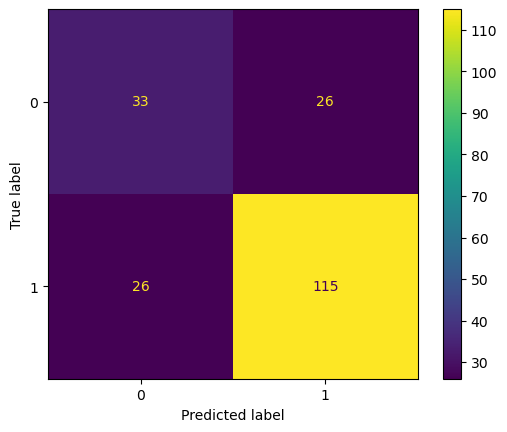

In [374]:
prob_mapping=prob_mapping_generator(new_threshold)

y_pred=prob_mapping(y_prob_0)>0.5
print(classification_report(y_test_target_0,y_pred))
cm=confusion_matrix(y_test_target_0,y_pred,labels=[1,0])
ConfusionMatrixDisplay(cm).plot()

เพื่อให้ได้ precision และ recall ของแต่ละคลาส ที่ดีที่สุดจึงเลือก Threshold 0.19